In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads(os.cpu_count())
from torch import nn

import importlib
import json

import matplotlib as mpl
import matplotlib.pyplot as plt

from pipnet import data
from pipnet import model
from pipnet import utils

import scipy
import scipy.io

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(123)

In [2]:
model_name = "PIPNet2D_model"
model_dir = f"../../trained_models/{model_name}/"
fig_dir = f"../../figures/2D/{model_name}/"

sel_wrs = [
    50000., 51000., 52000., 53000., 54000.,
    55000., 56000., 57000., 58000., 59000.,
    60000., 61000., 62000., 63000., 64000.,
    65000., 66000., 67000., 68000., 69000.,
    70000., 71000., 72000., 73000., 74000.,
    75000., 76000., 77000., 78000., 79000.,
    80000., 81000., 82000., 83000., 84000.,
    85000., 86000., 87000., 88000., 89000.,
    90000., 91000., 92000., 93000., 94000.,
    95000., 96000., 97000., 98000., 99000., 100000.
]

dw_max = 500.

ppm_range_x = [-5, 3.]
ppm_range_y = [-1.7, -1.2]

compounds = [
    #"20220216_ampicillin_baba_vmas_9",
    #"20220215_tyrosine_baba_vmas_9",
    #"20220216_ampicillin_baba_vmas_9_sheared",
    #"20220215_tyrosine_baba_vmas_9_sheared"
    "20230927_camphor_07mm_2DJres_vmas"
    #"20231003_camphor_07mm_2DJresph_vmas"
]

expnos = [1, 2, 3, 4, 5, 6]

exp_dir = "../../data/experimental_spectra/2D/"

In [3]:
if not os.path.exists(model_dir):
    raise ValueError(f"Unknown model: {model_name}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
    
fdir = fig_dir + "eval_experimental/"
if not os.path.exists(fdir):
    os.mkdir(fdir)

In [4]:
with open(f"{model_dir}model_pars.json", "r") as F:
    model_pars = json.load(F)
model_pars["noise"] = 0.

with open(f"{model_dir}data_pars.json", "r") as F:
    data_pars = json.load(F)

In [5]:
net = model.ConvLSTMEnsemble(**model_pars).to(device)
net.load_state_dict(torch.load(model_dir + f"network", map_location=torch.device(device)))
net = net.eval()

In [6]:
import importlib
importlib.reload(utils)

<module 'pipnet.utils' from '/Users/manuelcordova/Desktop/Work/PIP/PIPNet/src/pipnet/utils.py'>

In [8]:
compound = "20230927_camphor_07mm_2DJres_vmas"

In [9]:
ppm_x, ppm_y, hz_x, hz_y, ws, xrr, xri, xir, xii, titles, msg = utils.extract_2d_dataset(
        f"{exp_dir}{compound}/",
        procno=1,
        expnos=[7],
    )

In [24]:
xrr, xri, xir, xii, wr, ppm_x, ppm_y, hz_x, hz_y, title, msg = utils.load_2d_topspin_spectrum(
    f"{exp_dir}{compound}/7/",
    dtype=">i4"
)

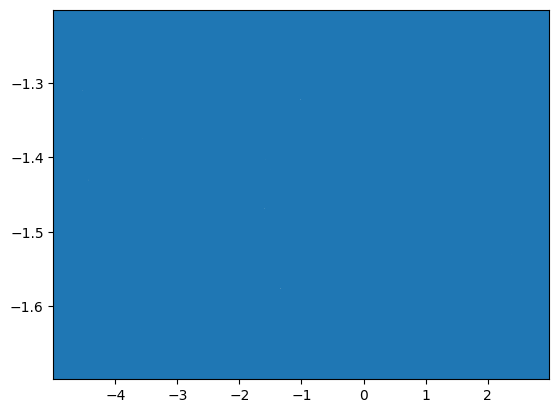

In [25]:
mask_x = np.logical_and(ppm_x >= ppm_range_x[0], ppm_x <= ppm_range_x[1])
mask_y = np.logical_and(ppm_y >= ppm_range_y[0], ppm_y <= ppm_range_y[1])
ppm_xx, ppm_yy = np.meshgrid(ppm_x[mask_x], ppm_y[mask_y])
xrr = xrr[mask_y][:, mask_x]
plt.contour(
    ppm_xx,
    ppm_yy,
    xrr / np.max(xrr),
    levels=[0.1, 0.3, 0.5],
    colors="C0",
    linewidths=1.
)
plt.show()
plt.close()

In [30]:
xrr, xri, xir, xii, wr, ppm_x, ppm_y, hz_x, hz_y, title, msg = utils.load_2d_topspin_spectrum(
    f"{exp_dir}{compound}/7/",
    dtype="<i4"
)

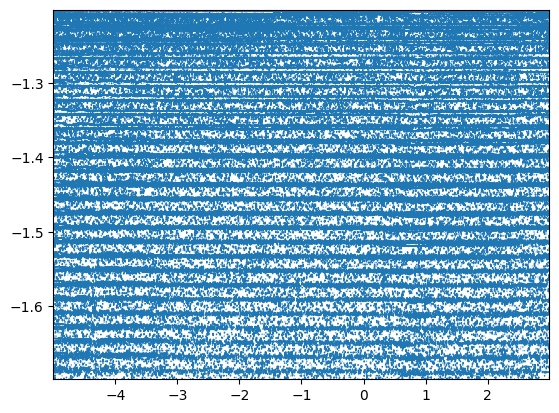

In [31]:
mask_x = np.logical_and(ppm_x >= ppm_range_x[0], ppm_x <= ppm_range_x[1])
mask_y = np.logical_and(ppm_y >= ppm_range_y[0], ppm_y <= ppm_range_y[1])
ppm_xx, ppm_yy = np.meshgrid(ppm_x[mask_x], ppm_y[mask_y])
xrr = xrr[mask_y][:, mask_x]
plt.contour(
    ppm_xx,
    ppm_yy,
    xrr / np.max(xrr),
    levels=[0.1, 0.3, 0.5],
    colors="C0",
    linewidths=1.
)
plt.show()
plt.close()

In [32]:
xrr, xri, xir, xii, wr, ppm_x, ppm_y, hz_x, hz_y, title, msg = utils.load_2d_topspin_spectrum(
    f"{exp_dir}{compound}/7/",
    dtype="=i4"
)

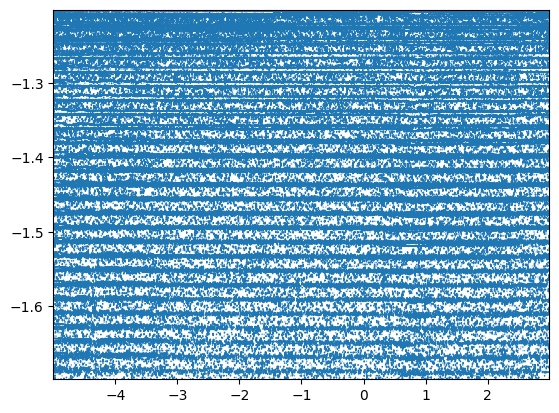

In [33]:
mask_x = np.logical_and(ppm_x >= ppm_range_x[0], ppm_x <= ppm_range_x[1])
mask_y = np.logical_and(ppm_y >= ppm_range_y[0], ppm_y <= ppm_range_y[1])
ppm_xx, ppm_yy = np.meshgrid(ppm_x[mask_x], ppm_y[mask_y])
xrr = xrr[mask_y][:, mask_x]
plt.contour(
    ppm_xx,
    ppm_yy,
    xrr / np.max(xrr),
    levels=[0.1, 0.3, 0.5],
    colors="C0",
    linewidths=1.
)
plt.show()
plt.close()

In [6]:
%%time

scale_factor = 1.

for compound in compounds:
    
    print(compound)

    print("  Loading dataset...")

    ppm_x, ppm_y, hz_x, hz_y, ws, xrr, xri, xir, xii, titles, msg = utils.extract_2d_dataset(
        f"{exp_dir}{compound}/",
        procno=1,
        expnos=expnos
    )

    inds_x = np.where(np.logical_and(ppm_x >= ppm_range_x[0], ppm_x <= ppm_range_x[1]))[0]
    inds_y = np.where(np.logical_and(ppm_y >= ppm_range_y[0], ppm_y <= ppm_range_y[1]))[0]

    ppm_x = ppm_x[inds_x]
    hz_x = hz_x[inds_x]
    xrr = xrr[:, :, inds_x]
    if data_pars["encode_imag"]:
        xri = xri[:, :, inds_x]
        xir = xir[:, :, inds_x]
        xii = xii[:, :, inds_x]

    ppm_y = ppm_y[inds_y]
    hz_y = hz_y[inds_y]
    xrr = xrr[:, inds_y, :]
    if data_pars["encode_imag"]:
        xri = xri[:, inds_y, :]
        xir = xir[:, inds_y, :]
        xii = xii[:, inds_y, :]

    print("  Preparing input...")
    
    X = utils.prepare_2d_input(xrr, ws, data_pars, xri=xri, xir=xir, xii=xii, xmax=1.)

    wr_inds = [np.argmin(np.abs(ws - w)) for w in sel_wrs if np.min(np.abs(ws - w)) < dw_max ]
    X = X[:, wr_inds]
    
    X[:, :, 0] *= scale_factor
    
    print("  Making prediction...")
    
    with torch.no_grad():
        y_pred, _, _ = net(X)
    y_pred = y_pred.numpy()
    
    print("  Saving results...")
    
    utils.plot_2d_iso_prediction(
        X[0].numpy().copy(),
        y_pred[0],
        xvals=ppm_x,
        yvals=ppm_y,
        wr_factor=data_pars["wr_norm_factor"],
        all_steps=True,
        show=False,
        level_neg=True,
        equal_axes=False,
        xinv=True,
        yinv=True,
        lw=0.1,
        save=f"{fdir}{compound}.pdf"
    )
    
    utils.plot_2d_iso_prediction(
        X[0].numpy().copy(),
        y_pred[0],
        xvals=ppm_x,
        yvals=ppm_y,
        wr_factor=data_pars["wr_norm_factor"],
        all_steps=True,
        show=False,
        level_min=0.01,
        level_neg=True,
        equal_axes=False,
        xinv=True,
        yinv=True,
        lw=0.1,
        save=f"{fdir}{compound}_low_contour.pdf"
    )
    
    output = {}
    output["ppm_x"] = ppm_x
    output["ppm_y"] = ppm_y
    output["X"] = X[0, :, 0].numpy()
    output["wr"] = ws[wr_inds]
    output["pred"] = y_pred[0, -1]
    
    scipy.io.savemat(f"{fdir}{compound}_preds.mat", output)

    print("  Done!")

20230927_camphor_07mm_2DJres_vmas
  Loading dataset...
  Preparing input...
  Making prediction...
  Saving results...
  Done!
CPU times: user 9min 49s, sys: 1min 54s, total: 11min 43s
Wall time: 3min 34s
